In [1]:
import numpy as np
import os
from spectral.io import envi
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

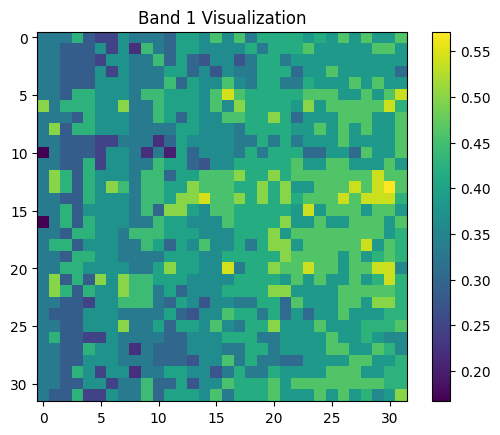

In [20]:

hsi_data = np.load('C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Wood_Datasets/Wood_Original/training/sapwood/cuboid_1.npy', allow_pickle= True)

# Write the BIL file
with open('cuboid_1.bil', 'wb') as f:
    
    hsi_data.transpose(1, 0, 2).tofile(f) 
    
# Define the metadata for the .hdr file
hdr_content = f"""ENVI
samples = {hsi_data.shape[1]}
lines   = {hsi_data.shape[0]}
bands   = {hsi_data.shape[2]}
header offset = 0
file type = ENVI Standard
data type = 4  # Float32
interleave = bil
byte order = 0
"""

# Write the HDR file
with open('cuboid_1.bil.hdr', 'w') as hdr_file:
    
    hdr_file.write(hdr_content)
    

# Open the BIL file using Rasterio
with rasterio.open('cuboid_1.bil') as dataset:
    # Read the first band (for visualization purposes)
    band1 = dataset.read(30)
    
    # Visualize the first band
    plt.imshow(band1)
    plt.colorbar()
    plt.title('Band 1 Visualization')
    plt.show()


In [4]:
def calculate_mean_spectrum(image_data):

    return np.mean(image_data, axis=(0, 1))  # 1D array (300,)



def reshape_spectrum(mean_spectrum):

    return mean_spectrum.reshape((1, 1, len(mean_spectrum)))  # (1, 1, 300)



def save_spectrum(mean_spectrum, output_spec_path):
    
    mean_spectrum_reshaped = reshape_spectrum(mean_spectrum)
    
    # Save the mean spectrum data (.spec)
    mean_spectrum_reshaped.tofile(output_spec_path)  # Save as a binary file



def save_spectrum_header(mean_spectrum, output_hdr_path):
    
    """Create and save a proper ENVI-style header (.spec.hdr) for the mean spectrum."""
    # Create a proper ENVI-style header
    
    hdr_data = {
        'samples': 1,  # Single pixel (spatial dimension)
        'lines': 1,    # Single line (spatial dimension)
        'bands': len(mean_spectrum),  # Number of spectral bands
        'header offset': 0,
        'file type': 'ENVI Standard',
        'data type': 4,  # 4 corresponds to 32-bit float in ENVI
        'interleave': 'bsq',  # Band sequential (BSQ)
        'byte order': 0,  # 0 = little-endian, 1 = big-endian
        'wavelength units': 'Nanometers',  # Optional, if you have wavelength units
        'band names': '{Mean Spectrum}'  # ENVI uses curly braces for list entries
    }
    
    
    # Write the header to the .spec.hdr file
    with open(output_hdr_path, 'w') as hdr_file:
        hdr_file.write("ENVI\n")  # ENVI headers must start with "ENVI"
        hdr_file.write("description = {Mean spectrum header}\n")  # Add description line
        
        # Write the rest of the ENVI header fields
        for key, value in hdr_data.items():
            hdr_file.write(f"{key} = {value}\n")



def create_output_structure(input_folder, output_base_folder, current_file):
    
    """Create the corresponding output folder structure."""
    relative_path = os.path.relpath(current_file, input_folder)
    relative_folder = os.path.dirname(relative_path)
    
    output_folder = os.path.join(output_base_folder, relative_folder)
    os.makedirs(output_folder, exist_ok=True)
    
    return output_folder



def process_hsi_images(input_folder, output_base_folder):
    
    """Recursively traverse the folder structure, load HSI images from .npy, and save the mean spectrum."""
    
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.npy'):
                # Get the .npy file path
                npy_path = os.path.join(root, file)
                
                # Load the hyperspectral image from .npy
                image_data = np.load(npy_path)  # This will be a numpy array
                
                # Calculate the mean spectrum
                mean_spectrum = calculate_mean_spectrum(image_data)
                
                # Create corresponding output folder structure
                output_folder = create_output_structure(input_folder, output_base_folder, npy_path)
                
                # Define the output .spec and .spec.hdr file paths in the new structure
                output_spec_path = os.path.join(output_folder, file.replace('.npy', '.spec'))
                output_hdr_path = os.path.join(output_folder, file.replace('.npy', '.spec.hdr'))
                
                # Save the mean spectrum
                save_spectrum(mean_spectrum, output_spec_path)
                
                # Save the corresponding ENVI header file (.spec.hdr)
                save_spectrum_header(mean_spectrum, output_hdr_path)
                
                print(f"Processed: {npy_path} -> {output_spec_path} and {output_hdr_path}")



if __name__ == "__main__":
    input_folder = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Wood_Datasets/Wood_Original'
    output_base_folder = 'C:/Users/rafin/Desktop/woodtest'
    
    process_hsi_images(input_folder, output_base_folder)

Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Wood_Datasets/Wood_Original\testing\heartwood\cuboid_11284.npy -> C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11284.spec and C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11284.spec.hdr
Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Wood_Datasets/Wood_Original\testing\heartwood\cuboid_11285.npy -> C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11285.spec and C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11285.spec.hdr
Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Wood_Datasets/Wood_Original\testing\heartwood\cuboid_11286.npy -> C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11286.spec and C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11286.spec.hdr
Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Wood_Datasets/Wood_Original\testin

In [5]:
#convert to .npy

def load_and_reshape_spec(spec_file, hdr_file):
    
    """Load the .spec file and reshape the data from (1, 1, 300) to (1, 300)."""
    
    # Load the .spec file using numpy
    
    data = np.fromfile(spec_file, dtype=np.float32)
    
    # Get the metadata from the .spec.hdr file
    hdr_data = envi.read_envi_header(hdr_file)
    
    # Check if the data shape is (1, 1, 300)
    lines = int(hdr_data['lines'])       # Should be 1
    samples = int(hdr_data['samples'])   # Should be 1
    bands = int(hdr_data['bands'])       # Should be 300
    
    if lines == 1 and samples == 1 and bands == len(data):
        
        # Reshape to (1, 1, 300)
        data = data.reshape((lines, samples, bands))
        
        # Reshape to (1, 300)
        reshaped_data = data.reshape((1, bands))
        
    else:
        
        raise ValueError(f"Unexpected shape in {spec_file}: expected (1, 1, 300), got {(lines, samples, bands)}")
    
    
    return reshaped_data



def create_output_structure(input_folder, output_base_folder, current_file):
    
    """Create the corresponding output folder structure in the output directory."""
    
    relative_path = os.path.relpath(current_file, input_folder)
    relative_folder = os.path.dirname(relative_path)
    
    output_folder = os.path.join(output_base_folder, relative_folder)
    os.makedirs(output_folder, exist_ok=True)
    
    
    return output_folder



def process_spec_files(input_folder, output_base_folder):
    
    """Traverse the folder structure, convert .spec and .spec.hdr files to .npy, and save them."""
    for root, dirs, files in os.walk(input_folder):
        
        for file in files:
            
            if file.endswith('.spec'):
                
                # Get the corresponding .spec and .spec.hdr paths
                spec_file = os.path.join(root, file)
                hdr_file = spec_file + '.hdr'
                
                if not os.path.exists(hdr_file):
                    print(f"Header file missing for {spec_file}, skipping.")
                    
                    continue
                
                
                # Load and reshape the .spec file
                try:
                    
                    reshaped_data = load_and_reshape_spec(spec_file, hdr_file)
                    
                except ValueError as e:
                    
                    print(f"Error processing {spec_file}: {e}")
                    
                    continue
                
                # Create corresponding output folder structure
                output_folder = create_output_structure(input_folder, output_base_folder, spec_file)
                
                # Define the output .npy file path
                output_npy_path = os.path.join(output_folder, file.replace('.spec', '.npy'))
                
                # Save the reshaped data as a .npy file
                np.save(output_npy_path, reshaped_data)
                
                print(f"Processed: {spec_file} -> {output_npy_path}")



if __name__ == "__main__":
    
    input_folder = 'C:/Users/rafin/Desktop/woodtest'
    output_base_folder = 'C:/Users/rafin/Desktop/woodtest_npy'
    process_spec_files(input_folder, output_base_folder)

Processed: C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11284.spec -> C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11284.npy
Processed: C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11285.spec -> C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11285.npy
Processed: C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11286.spec -> C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11286.npy
Processed: C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11287.spec -> C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11287.npy
Processed: C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11288.spec -> C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11288.npy
Processed: C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11289.spec -> C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11289.npy
Processed: C:/Users/rafin/Desktop/woodtest\testing\heartwood\cuboid_11290.spec -> 

In [6]:
#Labels
output_directory = 'C:/Users/rafin/Desktop/woodtest_npy'

# Initialize a dictionary for labels
labels = {}

for root, dirs, files in os.walk(output_directory):
    
    for file in files:
        
        if file.endswith('.npy'):
            
            # Full file path
            npy_file_path = os.path.join(root, file)
            
            # Load the NumPy array
            data = np.load(npy_file_path)
            
            # Extract the label from the folder name
            folder_name = os.path.basename(root)
            
            labels[npy_file_path] = folder_name  # Store the label


# Print all labels
print("Labels assigned based on folder names:")

for npy_file, label in labels.items():
    
    print(f"{npy_file}: {label}")

Labels assigned based on folder names:
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11284.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11285.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11286.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11287.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11288.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11289.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11290.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11291.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11292.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11293.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboid_11294.npy: heartwood
C:/Users/rafin/Desktop/woodtest_npy\testing\heartwood\cuboi

In [8]:
print(labels)

{'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_1.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_2.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_3.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_4.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_5.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_2PU_cube_1.

In [9]:
def load_and_concatenate_npy_files(root_dir, label_from='filename'):
    
    data = []
    labels = []

    for root, dirs, files in os.walk(root_dir):
        
        for file in files:
            
            if file.endswith(".npy"):
                
                # Load the .npy file
                npy_path = os.path.join(root, file)
                npy_data = np.load(npy_path)
                
                # Handle cases where the data may not be 1D and needs flattening
                if len(npy_data.shape) > 1:
                    
                    npy_data = npy_data.flatten()
                
                # Append the data and the corresponding label
                data.append(npy_data)
                
                # Determine the label based on filename or folder
                if label_from == 'filename':
                    
                    label = os.path.splitext(file)[0]  # Use filename without extension as label
                    
                elif label_from == 'folder':
                    
                    label = os.path.basename(root)  # Use folder name as label
                else:
                    
                    raise ValueError("label_from must be either 'filename' or 'folder'")
                
                labels.append(label)

    # Convert the data and labels into a pandas DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels

    return df

# Specify the root directory containing .npy files
#root_directory = 'C:/Users/rafin/Desktop/woodtest_npy/training'
root_directory = 'C:/Users/rafin/Desktop/woodtest_npy/testing'

# Set label_from to either 'filename' or 'folder'
label_source = 'folder'  # or 'folder'

# Get the concatenated data and labels
df = load_and_concatenate_npy_files(root_directory, label_from=label_source)


'''
df.to_csv("Wood_Training.csv", index=False)  
np.save("Wood_Training.npy", df.to_numpy())  
'''

df.to_csv("Wood_Testing.csv", index=False)  
np.save("Wood_Testing.npy", df.to_numpy())  

In [10]:
data = np.load('Wood_Testing.npy',allow_pickle = True)

print(data)
print(data.shape)

[[0.20376884937286377 0.2117655873298645 0.21193034946918488 ...
  0.3390067219734192 0.3441685438156128 'heartwood']
 [0.17629098892211914 0.18061266839504242 0.18257325887680054 ...
  0.3372628688812256 0.3426339626312256 'heartwood']
 [0.16574732959270477 0.17546430230140686 0.17388346791267395 ...
  0.3124302625656128 0.3158482313156128 'heartwood']
 ...
 [0.15014919638633728 0.1528128981590271 0.15268391370773315 ...
  0.2748326063156128 0.27358773350715637 'sapwood']
 [0.13655242323875427 0.1362464427947998 0.13839030265808105 ...
  0.2478000521659851 0.24835272133350372 'sapwood']
 [0.14059282839298248 0.14076223969459534 0.14316895604133606 ...
  0.2600499987602234 0.26061874628067017 'sapwood']]
(132, 321)
